<a href="https://colab.research.google.com/github/Maxlab/pytorch_learn/blob/master/StyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch

import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms, models
from torch import nn
from torch.optim import lr_scheduler
import torch.nn.functional as F
import PIL.ImageOps
import requests
from PIL import Image

device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")

In [34]:
model = models.vgg19(True).features
model
model.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [35]:
for name, child in model.named_children():
  print(name)

for name, child in model.named_children():
   if name in []:
       print(name + ' is unfrozen')
       for param in child.parameters():
           param.requires_grad = True
   else:
       print(name + ' is frozen')
       for param in child.parameters():
           param.requires_grad = False

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
0 is frozen
1 is frozen
2 is frozen
3 is frozen
4 is frozen
5 is frozen
6 is frozen
7 is frozen
8 is frozen
9 is frozen
10 is frozen
11 is frozen
12 is frozen
13 is frozen
14 is frozen
15 is frozen
16 is frozen
17 is frozen
18 is frozen
19 is frozen
20 is frozen
21 is frozen
22 is frozen
23 is frozen
24 is frozen
25 is frozen
26 is frozen
27 is frozen
28 is frozen
29 is frozen
30 is frozen
31 is frozen
32 is frozen
33 is frozen
34 is frozen
35 is frozen
36 is frozen


In [0]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.squeeze()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
  image = image.clip(0, 1)
  return image

def load_image(path, max_size=400, shape=None):
  image = Image.open(path).convert('RGB')
  if max(image.size) > max_size:
    size = max_size
  else:
    size = max(image.size)

  if shape is not None:
    size = shape

  in_transform = transforms.Compose([
                      transforms.Resize(size),
                      transforms.ToTensor(),
                      transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
  ])
  image = in_transform(image).unsqueeze(0)

  return image



In [37]:
content = load_image('City.jpg').to(device)
style = load_image('StarryNight.jpg', shape=content.shape[-2:]).to(device)
content.shape[-2:]

torch.Size([400, 600])

(-0.5, 599.5, 399.5, -0.5)

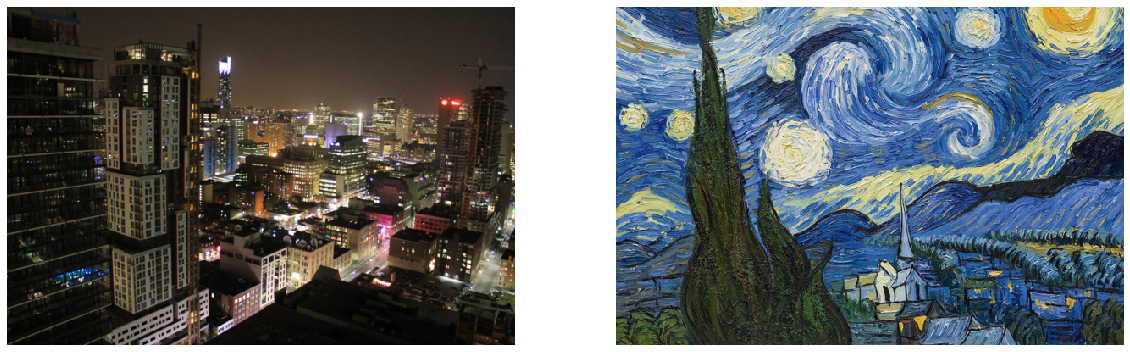

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')

In [0]:
def get_features(image, model):
  layers = {
      '0':  'conv1_1',
      '5':  'conv2_1',
      '10': 'conv3_1',
      '19': 'conv4_1',
      '21': 'conv4_2', #content extraction
      '28': 'conv5_1'
  }

  features = {}
  for name, layer in model._modules.items():
    image = layer(image)
    if name in layers:
      features[layers[name]] = image
  
  return features

In [0]:
content_features = get_features(content, model)
style_features = get_features(style, model)

In [0]:
def gram_matrix(tensor):
  _, d, h, w = tensor.size()
  tensor = tensor.view(d, h*w)
  gram = torch.mm(tensor, tensor.t())
  return gram

In [0]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}


In [0]:
style_weights = {
      'conv1_1': 1.,
      'conv2_1': .75,
      'conv3_1': .2,
      'conv4_1': .2,
      'conv5_1': .2
}

content_weight = 1.
style_weight   = 1e6


In [0]:
target = content.clone().requires_grad_(True).to(device)

In [42]:
model = model.to(device)


criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0006, momentum=0.9)
#optimizer = torch.optim.Adam(model.parameters(), lr=.001)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

epochs = 5
loss_history = []
corrects_history = []
val_loss_history = []
val_corrects_history = []


for e in range(epochs):
  loss = .0
  corrects = .0
  val_loss = .0
  val_corrects = .0

  for inputs, labels in training_loader:
    model.train()
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  

    _, preds = torch.max(outputs, 1)
    loss += loss.item()
    corrects += torch.sum(preds == labels.data)
 
  else:
    model.eval()
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)

        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)

        _, val_preds = torch.max(val_outputs, 1)
        val_loss += val_loss.item()
        val_corrects += torch.sum(val_preds == val_labels.data)
    
    count_tl = len(training_loader.dataset)
    epoch_loss = loss / count_tl
    epoch_acc  = corrects.float() / count_tl
    loss_history.append(epoch_loss)
    corrects_history.append(epoch_acc)

    val_epoch_loss = val_loss / len(validation_loader.dataset)
    val_epoch_acc  = val_corrects.float() / len(validation_loader.dataset)
    val_loss_history.append(val_epoch_loss)
    val_corrects_history.append(val_epoch_acc)


    print("Epoch: {}  Count_TrainLoader: {}  TrainAccrsy: {:.4f}  ValAccrsy: {:.4f}".format(e+1, count_tl, epoch_acc, val_epoch_acc))

NameError: ignored

In [0]:
url = 'https://www.scienceabc.com/wp-content/uploads/2017/11/Honey-bee.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

In [0]:
img = transform(img) 
plt.imshow(im_convert(img))

In [0]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

In [0]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))